## Nature's Cost Function: Simulating Physics by Minimizing the Action
Tim Strang, Isabella Caruso, and Sam Greydanus | 2023 | MIT License

The purpose of this simple post is to bring to attention a view of physics which isn't often communicated in introductory courses: the view of _physics as optimization_.

It begins with a quantity called the action. If you minimize the action, you can obtain a _path of least action_ which represents the path a physical system will take through space and time. Generally speaking, physicists use analytic tools to do this minimization. In this post, we are going to attempt something different and slightly crazy: minimizing the action with gradient descent. For simplicity, we're going to run our experiment on a very simple system: a free body in a gravitational field. And in order to put our approach in perspective, we're going to begin by reviewing the standard approaches to this kind of problem.

### Standard approaches

**The analytic approach.** Here you use algebra, calculus, and other mathematical tools to find a closed-form equation of motion for the system. It gives the state of the system as a function of time. For an object in free fall, the equation of motion would be

$$y(t)=-\frac{1}{2}gt^2+v_0t+y_0.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.mkdir('static') if not os.path.exists('static') else None

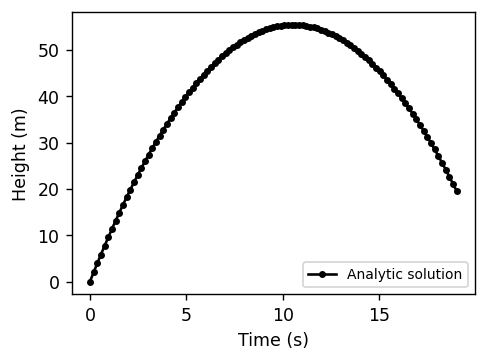

In [2]:
def falling_object_analytic(x0, x1, dt, g=1, steps=100):
    v0 = (x1 - x0) / dt
    t = np.linspace(0, steps, steps+1) * dt
    x = -.5*g*t**2 + v0*t + x0  # the equation of motion
    return t, x

x0, x1 = [0, 2]
dt = 0.19
t_ana, x_ana = falling_object_analytic(x0, x1, dt)

plt.figure(dpi=125,figsize=[4,3])
plt.plot(t_ana, x_ana, 'k.-', label='Analytic solution')
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8)
plt.tight_layout() ; plt.savefig('static/tutorial_ana.png') ; plt.show()

**The numerical approach.** Not all physics problems have an analytic solution. Some, like the double pendulum or the three-body problem, are deterministic but chaotic. In other words, their dynamics are predictable but we can't know their state at some time in the future without simulating all the intervening states. These we can solve with numerical integration:

$$\frac{\partial y}{\partial t} = v(t) \quad \textrm{and} \quad \frac{\partial v}{\partial t} = -g$$

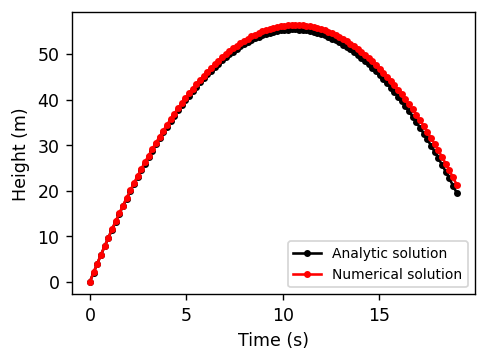

In [3]:
def falling_object_numerical(x0, x1, dt, g=1, steps=100):
    xs = [x0, x1]
    ts = [0, dt]
    v = (x1 - x0) / dt
    x = xs[-1]
    for i in range(steps-1):
        v += -g*dt
        x += v*dt
        xs.append(x)
        ts.append(ts[-1]+dt)
    return np.asarray(ts), np.asarray(xs)

t_num, x_num = falling_object_numerical(x0, x1, dt)

plt.figure(dpi=125,figsize=[4,3])
plt.plot(t_ana, x_ana, 'k.-', label='Analytic solution')
plt.plot(t_num, x_num, 'r.-', label='Numerical solution')
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8)
plt.tight_layout() ; plt.savefig('static/tutorial_num.png') ; plt.show()

<!-- ### Dynamics problems as optimization problems

**The Lagrangian method.** The approaches we just covered make intuitive sense. That's why we teach them in introductory physics classes. But there is an entirely different way of looking at dynamics called the Lagrangian method. The Lagrangian method does a better job of describing reality because it can produce equations of motion for _any_ physical system. Lagrangians figure prominently in all four branches of physics: classical mechanics, electricity and magnetism, thermodynamics, and quantum mechanics. Without the Lagrangian method, physicists would have a hard time unifying these disparate fields. But with the [Standard Model Lagrangian](https://www.symmetrymagazine.org/article/the-deconstructed-standard-model-equation) they can do precisely that.

**How it works.** The Lagrangian method begins by considering all the paths a physical system could take from an initial state $\bf x(t_0)$ to a final state $\bf x(t_1)$. Then it provides a simple rule for selecting the path $\hat{\bf x}$ that nature will actually take: the action $S$, defined in the equation below, must have a stationary value over this path. Here $T$ and $V$ are the kinetic and potential energy functions for the system at any given time $t$ in $[t_0,t_1]$.
$$
\begin{aligned}
S &:= \int_{t_0}^{t_1} L({\bf x}, ~ \dot{\bf x}, ~ t) ~ dt
\quad \textrm{where}\quad L = T - V \\
\quad \hat{\bf x} &~~ \textrm{has the property} \quad \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\hat{x}}(t)} \right) = \frac{\partial L}{\partial \hat{x}(t)} \quad \textrm{for} \quad t \in [t_0,t_1]
\end{aligned}
$$
**Finding $\hat{\bf x}$ with Euler-Lagrange (what people usually do).** When $S$ is stationary, we can show that the Euler-Lagrange equation (second line in the equations above) holds true over the interval $[t_0,t_1]$ (Morin, 2008). This observation is valuable because it allows us to solve for $\hat{\bf x}$: first we apply the Euler-Lagrange equation to the Lagrangian $L$ and derive a system of partial differential equations. Then we integrate those equations to obtain $\hat{\bf x}$. Importantly, this approach works for all problems spanning classical mechanics, electrodynamics, thermodynamics, and relativity. It provides a coherent theoretical framework for studying classical physics as a whole.

**Finding $\hat{\bf x}$ with action minimization (what we are going to do).** A more direct approach to finding $\hat{\bf x}$ begins with the insight that paths of stationary action are almost always _also_ paths of least action (Morin 2008). Thus, without much loss of generality, we can exchange the Euler-Lagrange equation for the simple minimization objective shown in the third part of the equationbelow. Meanwhile, as shown in the first part of the equationbelow, we can redefine $S$ as a discrete sum over $N$ evenly-spaced time slices:
$$
S := \sum_{i=0}^{N} L({\bf x}, ~ \dot{{\bf x}}, ~ t_i) \Delta t \quad \textrm{where} \quad \dot{{\bf x}}(t_i) := \frac{ {\bf x}(t_{i+1}) - {\bf x}(t_{i})}{\Delta t} \quad \textrm{and} \quad \hat{\bf x} := \underset{\bf x}{\textrm{argmin}} ~ S(\bf x)
$$
One problem remains: having discretized $\hat{ \bf x}$ we can no longer take its derivative to obtain an exact value for $\dot{ \bf x}(t_i)$. Instead, we must use the finite-differences approximation shown in the second part of the equation above. Of course, this approximation will not be possible for the very last $\dot{ \bf x}$ in the sum because $\dot{ \bf x}_{N+1}$ does not exist. For this value we will assume that, for large $N$, the change in velocity over the interval $\Delta t$ is small and thus let $\dot{ \bf x}_N = \dot{ \bf x}_{N-1}$. Having made this last approximation, we can now compute the gradient $\frac{\partial S}{\partial {\bf x}}$ numerically and use it to minimize $S$. This can be done with PyTorch (Paszke et al, 2019) or any other package that supports automatic differentiation.

### A simple implementation

Let's begin with a list of coordinates, `x`, which contains all the position coordinates of the system between t\\(_1\\) and t\\(_2\\). We can write the Lagrangian and the action of the system in terms of these coordinates.  -->

### Dynamics problems as optimization problems

**The Lagrangian method.** The approaches we just covered make intuitive sense. That's why we teach them in introductory physics classes. But there is an entirely different way of looking at dynamics called the Lagrangian method. The Lagrangian method does a better job of describing reality because it can produce equations of motion for _any_ physical system. Lagrangians figure prominently in all four branches of physics: classical mechanics, electricity and magnetism, thermodynamics, and quantum mechanics. Without the Lagrangian method, physicists would have a hard time unifying these disparate fields. But with the [Standard Model Lagrangian](https://www.symmetrymagazine.org/article/the-deconstructed-standard-model-equation) they can do precisely that.

Many of the details of the Lagrangian method are beyond the scope of this work. However, this half-page from David Morin's _Introduction to Classical Mechanics_ does a good job of setting the scene:

![Morin](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/morin_ch6.png)

Earlier in the chapter, Morin asks us to take his word for the fact that L, the Lagrangian, is the difference between the potential and kinetic energy. For a falling particle, L would be \\(\mathcal{L}=T-V=\frac{1}{2}m\dot{y}^2-mgy_0\\). From there, Morin shows that we can use Equation 6.15 to obtain an equation of motion for the system.

**Discretizing the action** In the screenshot above, Morin mentions as an aside, _"If you don’t like infinities, you can imagine breaking up the time interval into, say, a million pieces, and then replacing the integral by a discrete sum."_ The goal of this sentence was to make the idea of a functional more intuitive -- not to provide practical advice for computing the action. But what if we took this sentence literally? What if we used a computer to estimate S (a scalar) and then searched for its stationary values using numerical optimization? In doing so, we could obtain the dynamics of the physical system between times t\\(_1\\) and t\\(_2\\).

### A simple implementation

Let's begin with a list of coordinates, `x`, which contains all the position coordinates of the system between t\\(_1\\) and t\\(_2\\). We can write the Lagrangian and the action of the system in terms of these coordinates. 

In [4]:
def lagrangian_freebody(x, xdot, m=1, g=1):
    T = .5*m*xdot**2
    V = m*g*x
    return T, V
  
def action(x, dt):
    xdot = (x[1:] - x[:-1]) / dt
    xdot = torch.cat([xdot, xdot[-1:]], axis=0)
    T, V = lagrangian_freebody(x, xdot)
    return T.sum()-V.sum()

Now let's look for a point of stationary action. Technically, this could be a minimum, a maximum, or an inflection point. Here, though, we're just going to look for a minimum:

In [5]:
import torch
def get_path_between(x, steps=1000, step_size=1e-1, dt=1, num_prints=8, num_stashes=80):
    t = np.linspace(0, len(x)-1, len(x)) * dt
    print_on = np.linspace(0,int(np.sqrt(steps)),num_prints).astype(np.int32)**2 # print more often early in loop
    stash_on = np.linspace(0,int(np.sqrt(steps)),num_stashes).astype(np.int32)**2
    xs = []
    for i in range(steps):
        grad_x = torch.autograd.grad(action(x, dt), x)[0]
        grad_x[[0,-1]] *= 0  # fix first and last coordinates by zeroing their grads
        x.data -= grad_x * step_size

        if i in print_on:
            print('step={:04d}, S={:.4e} J*s'.format(i, action(x, dt).item()))
        if i in stash_on:
            xs.append(x.clone().data.numpy())
    return t, x, np.stack(xs)

Now let's put it all together. We can initialize our falling particle's path to be any random path through space. In the code below, we choose a path where the particle bounces around x=0 at random until time t=19 seconds, at which point it leaps up to its final state of x = `x_num[-1]` = 21.3 meters. This path has a high action of S = 5330 J·s. As we run the optimization, this value decreases smoothly until we converge on a parabolic arc with an action of S = -2500 J·s.

step=0000, S=5.4247e+03 J*s
step=0400, S=-4.6290e+02 J*s
step=1600, S=-1.4937e+03 J*s
step=3600, S=-2.1677e+03 J*s
step=6400, S=-2.4291e+03 J*s
step=10000, S=-2.4901e+03 J*s
step=14400, S=-2.4990e+03 J*s
step=19881, S=-2.4998e+03 J*s


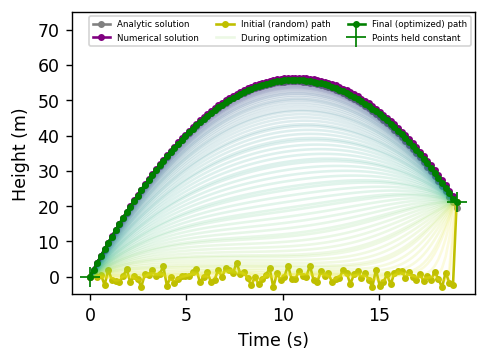

In [6]:
dt = 0.19
x0 = 1.5*torch.randn(len(x_num), requires_grad=True)  # a random path through space
x0[0].data *= 0.0 ; x0[-1].data *= 0.0  # set first and last points to zero
x0[-1].data += x_num[-1]  # set last point to be the end height of the numerical solution

t, x, xs_ncf = get_path_between(x0.clone(), steps=20000, step_size=1e-2, dt=dt)

plt.figure(dpi=125,figsize=[4,3])
# plt.title('Minimizing the Action')
plt.plot(t_ana, x_ana, '.-', color='gray', label='Analytic solution')
plt.plot(t_num, x_num, '.-', color='purple', label='Numerical solution')

plt.plot(t, x0.detach().numpy(), 'y.-', label='Initial (random) path')
for i, xi in enumerate(xs_ncf):
    label = 'During optimization' if i==15 else None
    plt.plot(t, xi, alpha=0.15, color=plt.cm.viridis( 1-i/(len(xs_ncf)-1) ), label=label)
plt.plot(t, x.detach().numpy(), 'g.-', label='Final (optimized) path')
plt.plot(t[[0,-1]], x0.data[[0,-1]], 'g+', markersize=12, label='Points held constant')

plt.ylim(-5, 75)
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=5, ncol=3)
plt.tight_layout() ; plt.savefig('static/tutorial_action.png') ; plt.show()

### Make a video of the simulation process

In [7]:
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [8]:
def make_video(t, xs, path, interval=60, color='black', mode='ncf', **kwargs): # xs: [time, N, 2]
    fig = plt.gcf() ; fig.set_dpi(200) ; fig.set_size_inches(3, 3)
    camera = Camera(fig)
    for i in range(len(xs) if type(xs) is list else xs.shape[0]):
        if mode == 'ncf':
            for j, xi in enumerate(xs[:i]):
                plt.plot(t, xi, alpha=0.15, color=plt.cm.viridis( 1-j/(len(xs)-1) ), label=label)
            plt.plot(t, xs[0], '.-', color=plt.cm.viridis(0.9))
        plt.plot(t[[0,-1]], xs[-1][[0,-1]], '+', color=color, markersize=16)
        plt.plot(t[:len(xs[i])], xs[i], '.-', color=color)
        plt.xlim(np.min(t)-1, np.max(t)+1) ; plt.ylim(-5, 75)
        plt.xticks([], []); plt.yticks([], []) ; plt.xlabel('Time (s)') ; plt.ylabel('Height (m)')
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path) ; plt.close()

In [9]:
xs_ncf_ = np.concatenate([xs_ncf[:1]]*20+[xs_ncf]+[xs_ncf[-1:]]*20 )
make_video(t, xs_ncf_, path='static/tutorial_ncf.mp4', color='green', interval=80)

mp4 = open('static/tutorial_ncf.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [10]:
xs_ana = [x_ana[:1]]*20 + [x_ana[:i+1] for i in range(len(x_ana)-1)]
xs_ana += [xs_ana[-1]]*20
make_video(t, xs_ana, path='static/tutorial_num.mp4', color='purple', mode='ode', interval=80)
mp4 = open('static/tutorial_num.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

### Closing thoughts

The goal of this work is to show that this technique is possible. Determining whether it has useful applications is a question for another day. Nevertheless, I'm going to make a few speculations:

**ODE super-resolution.** 

**Infilling missing data.** Some chaotic deterministic systems

**When the final state is irrelevant.** There are many simulation scenarios where the final state is not important at all. What really matters is that the dynamics look realistic in between times t\\(_1\\) and t\\(_2\\). This is the case for simulated smoke in a video game: the smoke just needs to look realistic. With that in mind, we could choose a random final state and then minimize the action of the intervening states. This could allow us to obtain realistic graphics more quickly than numerical methods that don't fix the final state.

The thing that I like most about this little experiment is that it shows how the action really does act like a cost function. This isn't something you'll hear in your physics courses, even high level ones. And yet, it's quite surprising and interesting to learn that nature has a cost function! The action is a very, very fundamental quantity. In a future post, we'll see how this notion extends even into quantum mechanics - with a few modifications of course.

<!-- Basic physical principles and the elegant reasoning behind them are often obscured in the midst of numerical approximations and domain-specific notation. This post shows that it's surprisingly easy to solve physics by working directly in terms of the action. It lets us solve simulation problems as though they are optimization problems -- a surprising result! -->